# Checkpoint 3

Implement here your algorithm to estimate the parametric field from timings recorded in the 20 electrodes of the mapping catheter.

The algorithm should output the following information:
- your estimates of parametric field


In [25]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import ray



In [26]:
CP3data = np.load("CP3data.npz")
CP3data = CP3data['arr_0']

## Autoencoder for compressed representation

In [27]:
#!pip install -U tensorflow==2.16.1

In [28]:
seed = 182374

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
#tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

2.16.1


In [29]:
CP3estimate = np.load("CP3field.npz")
CP3estimate = CP3estimate['arr_0']

In [30]:
autoencoder = tfk.models.load_model('autoencoder_8ldim.keras')

decoder_input = tf.keras.Input(shape=autoencoder.layers[4].output.shape[1:])
#print(decoder_input)
decoder_output = decoder_input
for layer in autoencoder.layers[5:]:
    decoder_output = layer(decoder_output)

In [31]:
decoder = tfk.Model(decoder_input, decoder_output)
encoder = tfk.models.load_model('encoder_8ldim.keras')

In [32]:
min_sf = np.min(CP3estimate[:,0])
max_sf = np.max(CP3estimate[:,0])

speed_fields = CP3estimate[:,0]

sf_norm = (speed_fields-min_sf)/(max_sf-min_sf)

### Compressed representation

In [33]:
speed_fields_low = np.zeros((100,8))

print(speed_fields_low.shape)


for i in range(100):
    speed_fields_low[i] = encoder.predict(sf_norm[i].reshape((1,151,151)))

(100, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1

In [34]:
speed_fields_low.shape

(100, 8)

In [35]:
np.save('CP3_estimate_compressed_8ldim.npz',speed_fields_low)

### Investigating distribution of every component of the low representation

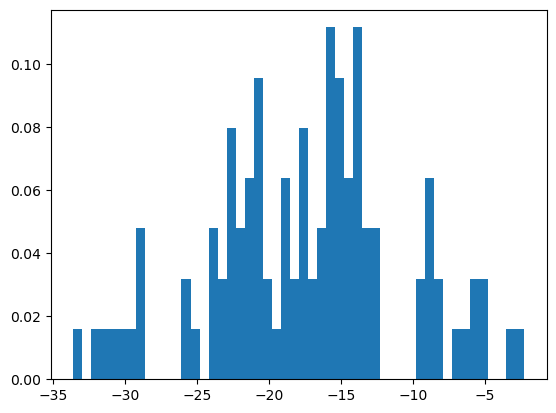

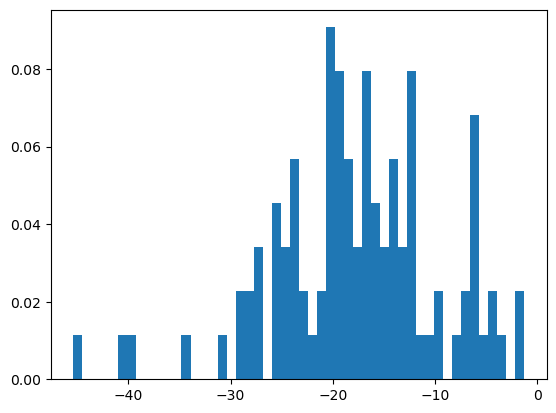

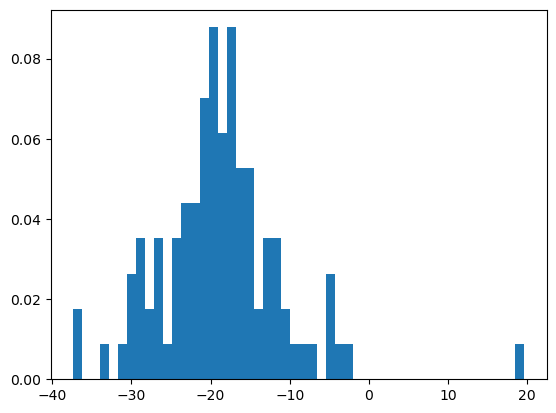

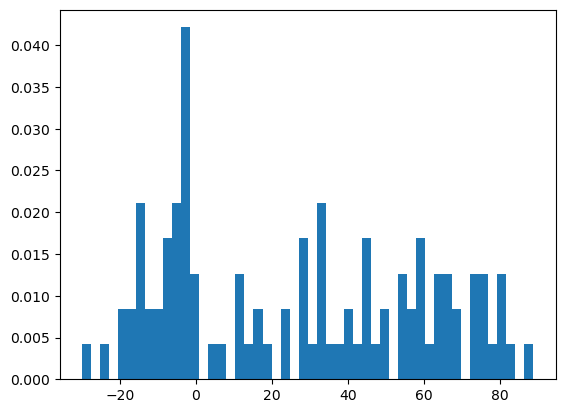

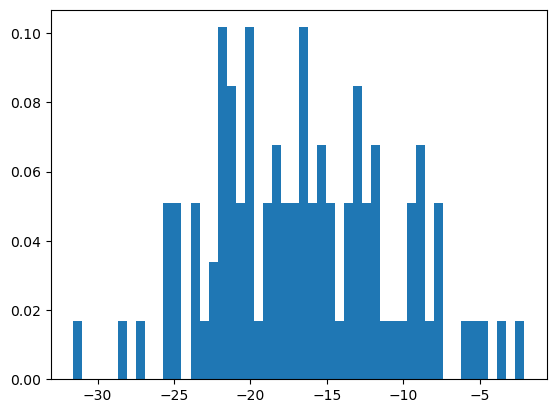

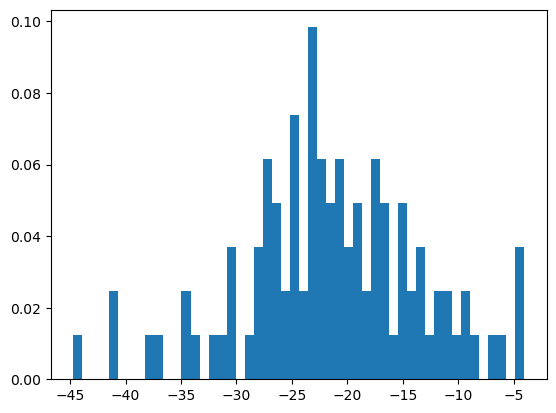

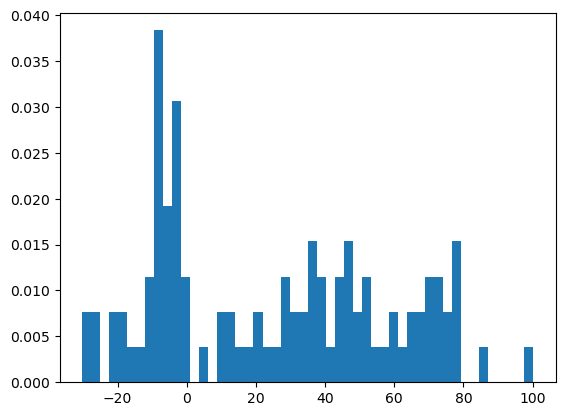

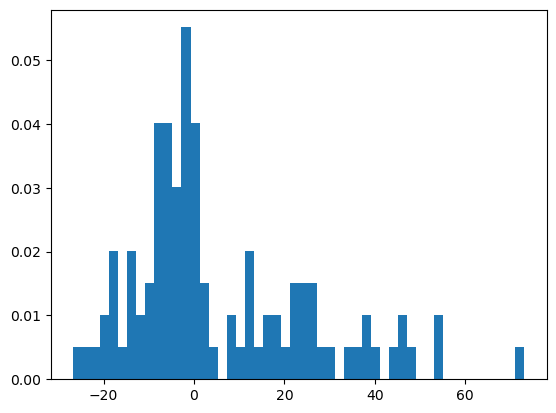

In [36]:
import matplotlib.pyplot as plt

ldim = 8

for i in range(ldim):
    plt.figure(i)
    plt.hist(speed_fields_low[:,i], bins = 50, density=True)

In [37]:
def anysotropic_FMM( x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22, speed_field ):

    s = 150



    (j,i)= ( (np.abs(X-x0)).argmin(1)[0] , (np.abs(Y-y0)).argmin(0)[0]  )
    #print( i,j )
    #print(x0,y0)
    #print(X[i,j], Y[i,j])
    #print()

    T = (10^4)*(np.ones(np.shape(X)))
    T[i,j] = 0

    T_final = (10^4)*(np.ones(np.shape(X)))
    T_final[i,j] = 0

    TRIAL = [ (i,j) ]
    KNOWN = []
    KNOWN_C = []
    CHANGED = []

    KNOWN_MAT = (np.zeros(np.shape(X)))
    CHANGED_MAT = (np.zeros(np.shape(X)))


    def update_fun( T_xi,T_x,T_y, X_xi, X_x, X_y, Y_xi, Y_x, Y_y, flag_known, speed_val):

        if ( flag_known ):
            triangle_list = [ p*T_x+(1-p)*T_y + np.sqrt( sigma_11*( p*(X_xi-X_x) + (1-p)*(X_xi-X_y) )**2 + 2*sigma_12*( p*(X_xi-X_x) + (1-p)*(X_xi-X_y) )*( p*(Y_xi-Y_x) + (1-p)*(Y_xi-Y_y) ) + sigma_22*( p*(Y_xi-Y_x) + (1-p)*(Y_xi-Y_y) )**2 )/speed_val for p in np.arange(0,1.1,0.1)]
            T_xi = np.min( [ T_xi , np.min(triangle_list) ] )
        else:
            T_xi = np.min( [ T_xi , T_x + np.sqrt( sigma_11*( (X_xi-X_x) )**2 + 2*sigma_12*( (X_xi-X_x) )*( Y_xi-Y_x ) + sigma_22*( Y_xi-Y_x )**2 )/speed_val ] )

        return T_xi

    while (np.shape(TRIAL)[0]>0) | (np.shape(CHANGED)[0]>0):

        if (np.shape(CHANGED)[0]==0):
            ind_sel =  ( np.array([T_final[i,j] for (i,j) in TRIAL]) ).argmin()
            (i_sel,j_sel) = TRIAL[ind_sel]
            # add X to known
            KNOWN.append( TRIAL[ind_sel] )
            KNOWN_MAT[i_sel,j_sel] = 1
            # remove X from trial
            del TRIAL[ind_sel]
        else:
            ind_sel =  ( np.array([T_final[i,j] for (i,j) in CHANGED]) ).argmin()
            (i_sel,j_sel) = CHANGED[ind_sel]
            CHANGED_MAT[i_sel,j_sel] = 0
            # remove X from changed
            del CHANGED[ind_sel]

        T_X = T[i_sel,j_sel]

        # UPDATE 1

        if (i_sel!=0):

            #if ((i_sel-1,j_sel) in KNOWN ):
            if (KNOWN_MAT[i_sel-1,j_sel] == 1 ):

                #T[i_sel-1,j_sel] = 10^4

                if (j_sel!=s):

                    T[i_sel-1,j_sel] = update_fun(T_xi = T[i_sel-1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel+1],
                                                X_xi = X[i_sel-1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel+1],
                                                    Y_xi= Y[i_sel-1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel+1] == 1 ),
                                                    speed_val = speed_field[i_sel-1,j_sel] )


                if (j_sel!=0):
                    #if ((i_sel-1,j_sel-1) in KNOWN ):

                    T[i_sel-1,j_sel] = update_fun(T_xi = T[i_sel-1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel-1],
                                                X_xi = X[i_sel-1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel-1],
                                                    Y_xi= Y[i_sel-1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel-1] == 1 ),
                                                    speed_val = speed_field[i_sel-1,j_sel]  )


                # if ((i_sel-1,j_sel) not in TRIAL ):
                #     TRIAL.append( (i_sel-1,j_sel) )
                if ( CHANGED_MAT[i_sel-1,j_sel] != 1 ):
                    if ( T[i_sel-1,j_sel] < T_final[i_sel-1,j_sel] ):
                        T_final[i_sel-1,j_sel] = T[i_sel-1,j_sel]
                        CHANGED.append( (i_sel-1,j_sel) )
                        CHANGED_MAT[i_sel-1,j_sel] = 1

        if (j_sel!=0):
            #if ((i_sel,j_sel-1) in KNOWN ):
            if (KNOWN_MAT[i_sel,j_sel-1] == 1 ):

                #T[i_sel,j_sel-1] = 10^4


                if (i_sel!=s):
                    #if ((i_sel+1,j_sel-1) in KNOWN ):

                    T[i_sel,j_sel-1] = update_fun(T_xi = T[i_sel,j_sel-1],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel-1],
                                                X_xi = X[i_sel,j_sel-1], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel-1],
                                                    Y_xi= Y[i_sel,j_sel-1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel-1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel-1] )


                if (i_sel!=0):
                    #if ((i_sel-1,j_sel-1) in KNOWN ):

                    T[i_sel,j_sel-1] = update_fun(T_xi = T[i_sel,j_sel-1],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel-1],
                                                X_xi = X[i_sel,j_sel-1], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel-1],
                                                    Y_xi= Y[i_sel,j_sel-1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel-1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel-1] )

                #if ((i_sel,j_sel-1) not in TRIAL ):
                #    TRIAL.append( (i_sel,j_sel-1) )
                if ( CHANGED_MAT[i_sel,j_sel-1] != 1 ):
                    if ( T[i_sel,j_sel-1] < T_final[i_sel,j_sel-1] ):
                        T_final[i_sel,j_sel-1] = T[i_sel,j_sel-1]
                        CHANGED.append( (i_sel,j_sel-1) )
                        CHANGED_MAT[i_sel,j_sel-1] = 1
                    #T[i_sel,j_sel-1] = T[i_sel,j_sel] + np.sqrt( ( X[i_sel,j_sel-1]-X[i_sel,j_sel] )**2 + ( Y[i_sel,j_sel-1]-Y[i_sel,j_sel] )**2 )/100

        if (i_sel!=s):
            #if ((i_sel+1,j_sel) in KNOWN ):
            if (KNOWN_MAT[i_sel+1,j_sel] == 1 ):

                #T[i_sel+1,j_sel] = 10^4

                if (j_sel!=s):
                    #if ((i_sel+1,j_sel+1) in KNOWN ):

                    T[i_sel+1,j_sel] = update_fun(T_xi = T[i_sel+1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel+1],
                                                X_xi = X[i_sel+1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel+1],
                                                    Y_xi= Y[i_sel+1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel+1,j_sel] )

                if (j_sel!=0) :
                    #if ((i_sel+1,j_sel-1) in KNOWN ):

                    T[i_sel+1,j_sel] = update_fun(T_xi = T[i_sel+1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel-1],
                                                X_xi = X[i_sel+1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel-1],
                                                    Y_xi= Y[i_sel+1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel-1] == 1 ) ,
                                                    speed_val = speed_field[i_sel+1,j_sel] )

                # if ((i_sel+1,j_sel) not in TRIAL ):
                #     TRIAL.append( (i_sel+1,j_sel) )
                if ( CHANGED_MAT[i_sel+1,j_sel] != 1 ):
                    if ( T[i_sel+1,j_sel] < T_final[i_sel+1,j_sel] ):
                        T_final[i_sel+1,j_sel] = T[i_sel+1,j_sel]
                        CHANGED.append( (i_sel+1,j_sel) )
                        CHANGED_MAT[i_sel+1,j_sel] = 1

        if (j_sel!=s):
            #if ((i_sel,j_sel+1) in KNOWN ):
            if (KNOWN_MAT[i_sel,j_sel+1] == 1 ):

                #T[i_sel,j_sel+1] = 10^4

                if (i_sel!=s):
                    #if ((i_sel+1,j_sel+1) in KNOWN ):
                    T[i_sel,j_sel+1] = update_fun(T_xi = T[i_sel,j_sel+1],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel+1],
                                                X_xi = X[i_sel,j_sel+1], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel+1],
                                                    Y_xi= Y[i_sel,j_sel+1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel+1] )

                if (i_sel!=0):
                    #if ((i_sel-1,j_sel+1) in KNOWN ):

                    T[i_sel,j_sel+1] = update_fun(T_xi = T[i_sel,j_sel+1],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel+1],
                                                X_xi = X[i_sel,j_sel+1], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel+1],
                                                    Y_xi= Y[i_sel,j_sel+1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel+1] )


                # if ((i_sel,j_sel+1) not in TRIAL ):
                #     TRIAL.append( (i_sel,j_sel+1) )
                if ( CHANGED_MAT[i_sel,j_sel+1] != 1 ):
                    if ( T[i_sel,j_sel+1] < T_final[i_sel,j_sel+1] ):
                        T_final[i_sel,j_sel+1] = T[i_sel,j_sel+1]
                        CHANGED.append( (i_sel,j_sel+1) )
                        CHANGED_MAT[i_sel,j_sel+1] = 1

        # UPDATE 2

        if (i_sel!=0):

            #if ((i_sel-1,j_sel) not in KNOWN ) :
            if (KNOWN_MAT[i_sel-1,j_sel] != 1 ):

                T[i_sel-1,j_sel] = 10^4

                if (j_sel!=s):
                    #if ((i_sel-1,j_sel+1) in KNOWN ):

                    T[i_sel-1,j_sel] = update_fun(T_xi = T[i_sel-1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel+1],
                                                X_xi = X[i_sel-1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel+1],
                                                    Y_xi= Y[i_sel-1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel-1,j_sel] )

                if (j_sel!=0):
                    #if ((i_sel-1,j_sel-1) in KNOWN ):

                    T[i_sel-1,j_sel] = update_fun(T_xi = T[i_sel-1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel-1],
                                                X_xi = X[i_sel-1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel-1],
                                                    Y_xi= Y[i_sel-1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel-1] == 1 ) ,
                                                    speed_val = speed_field[i_sel-1,j_sel] )

                if ((i_sel-1,j_sel) in TRIAL ):
                    if ( T[i_sel-1,j_sel] < T_final[i_sel-1,j_sel] ):
                        T_final[i_sel-1,j_sel] = T[i_sel-1,j_sel]
                else: # ((i_sel-1,j_sel) not in KNOWN ):
                    if ( T[i_sel-1,j_sel] < T_final[i_sel-1,j_sel] ):
                        T_final[i_sel-1,j_sel] = T[i_sel-1,j_sel]
                    #KNOWN_C.append( (i_sel-1,j_sel) )
                    TRIAL.append( (i_sel-1,j_sel) )

        if (j_sel!=0):
            #if ((i_sel,j_sel-1) not in KNOWN ) :
            if (KNOWN_MAT[i_sel,j_sel-1] != 1 ):

                T[i_sel,j_sel-1] = 10^4


                if (i_sel!=s):
                    #if ((i_sel+1,j_sel-1) in KNOWN ):

                    T[i_sel,j_sel-1] = update_fun(T_xi = T[i_sel,j_sel-1],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel-1],
                                                X_xi = X[i_sel,j_sel-1], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel-1],
                                                    Y_xi= Y[i_sel,j_sel-1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel-1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel-1] )

                if (i_sel!=0):
                    #if ((i_sel-1,j_sel-1) in KNOWN ):

                    T[i_sel,j_sel-1] = update_fun(T_xi = T[i_sel,j_sel-1],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel-1],
                                                X_xi = X[i_sel,j_sel-1], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel-1],
                                                    Y_xi= Y[i_sel,j_sel-1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel-1] == 1 ),
                                                    speed_val = speed_field[i_sel,j_sel-1]  )


                if ((i_sel,j_sel-1) in TRIAL ):
                    if ( T[i_sel,j_sel-1] < T_final[i_sel,j_sel-1] ):
                        T_final[i_sel,j_sel-1] = T[i_sel,j_sel-1]
                else : # ((i_sel,j_sel-1) not in KNOWN ):
                    if ( T[i_sel,j_sel-1] < T_final[i_sel,j_sel-1] ):
                        T_final[i_sel,j_sel-1] = T[i_sel,j_sel-1]
                    #KNOWN_C.append( (i_sel,j_sel-1) )
                    TRIAL.append( (i_sel,j_sel-1) )
                #T[i_sel,j_sel-1] = T[i_sel,j_sel] + np.sqrt( ( X[i_sel,j_sel-1]-X[i_sel,j_sel] )**2 + ( Y[i_sel,j_sel-1]-Y[i_sel,j_sel] )**2 )/100

        if (i_sel!=s):
            #if ((i_sel+1,j_sel) not in KNOWN ) :
            if (KNOWN_MAT[i_sel+1,j_sel] != 1 ):

                T[i_sel+1,j_sel] = 10^4

                if (j_sel!=s):
                    #if ((i_sel+1,j_sel+1) in KNOWN ):

                    T[i_sel+1,j_sel] = update_fun(T_xi = T[i_sel+1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel+1],
                                                X_xi = X[i_sel+1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel+1],
                                                    Y_xi= Y[i_sel+1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel+1],
                                                    flag_known = (KNOWN_MAT[i_sel+1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel+1,j_sel] )

                if (j_sel!=0) :
                    #if ((i_sel+1,j_sel-1) in KNOWN ):

                    T[i_sel+1,j_sel] = update_fun(T_xi = T[i_sel+1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel-1],
                                                X_xi = X[i_sel+1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel-1],
                                                    Y_xi= Y[i_sel+1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel-1],
                                                    flag_known = (KNOWN_MAT[i_sel+1,j_sel-1] == 1 ),
                                                    speed_val = speed_field[i_sel+1,j_sel]  )


                if ((i_sel+1,j_sel) in TRIAL ):
                    if ( T[i_sel+1,j_sel] < T_final[i_sel+1,j_sel] ):
                        T_final[i_sel+1,j_sel] = T[i_sel+1,j_sel]
                else: #if ((i_sel+1,j_sel) not in KNOWN ):
                    if ( T[i_sel+1,j_sel] < T_final[i_sel+1,j_sel] ):
                        T_final[i_sel+1,j_sel] = T[i_sel+1,j_sel]
                    #KNOWN_C.append( (i_sel+1,j_sel) )
                    TRIAL.append( (i_sel+1,j_sel) )

        if (j_sel!=s):
            #if ((i_sel,j_sel+1) not in KNOWN ) :
            if (KNOWN_MAT[i_sel,j_sel+1] != 1 ):

                T[i_sel,j_sel+1] = 10^4

                if (i_sel!=s):
                    #if ((i_sel+1,j_sel+1) in KNOWN ):

                    T[i_sel,j_sel+1] = update_fun(T_xi = T[i_sel,j_sel+1],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel+1],
                                                X_xi = X[i_sel,j_sel+1], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel+1],
                                                    Y_xi= Y[i_sel,j_sel+1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel+1],
                                                    flag_known = (KNOWN_MAT[i_sel+1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel+1] )

                if (i_sel!=0):
                    #if ((i_sel-1,j_sel+1) in KNOWN ):

                    T[i_sel,j_sel+1] = update_fun(T_xi = T[i_sel,j_sel+1],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel+1],
                                                X_xi = X[i_sel,j_sel+1], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel+1],
                                                    Y_xi= Y[i_sel,j_sel+1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel+1],
                                                    flag_known = (KNOWN_MAT[i_sel-1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel+1]  )


                if ((i_sel,j_sel+1) in TRIAL ):
                    if ( T[i_sel,j_sel+1] < T_final[i_sel,j_sel+1] ):
                        T_final[i_sel,j_sel+1] = T[i_sel,j_sel+1]
                else: #if ((i_sel,j_sel+1) not in KNOWN ):
                    if ( T[i_sel,j_sel+1] < T_final[i_sel,j_sel+1] ):
                        T_final[i_sel,j_sel+1] = T[i_sel,j_sel+1]
                    #KNOWN_C.append( (i_sel,j_sel+1) )
                    TRIAL.append( (i_sel,j_sel+1) )

    return T_final

## Minimization



In [38]:
from sklearn.metrics import mean_squared_error as mse
from scipy.interpolate import interp2d
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

x0 = 1.5
y0 = 1.3958493584010112
theta_fiber = -0.3141592653589793
a_ratio = 2.381068181818181

theta0 = np.pi/2 - theta_fiber
a = np.array([np.cos(theta0), np.sin(theta0)]).T
b = np.array([np.cos(theta0-np.pi/2), np.sin(theta0-np.pi/2)]).T

D = ( (1/a_ratio)*np.tensordot( a, a,  axes=0) + np.tensordot( b, b,  axes=0)  )
#print(D)

D_inv = np.linalg.inv(D)
sigma_11 = D_inv[0][0]
sigma_12 = D_inv[0][1]
sigma_21 = D_inv[1][0]
sigma_22 = D_inv[1][1]

N = 151
X, Y = np.meshgrid(np.linspace(-1.5,1.5,N), np.linspace(-1.5,1.5,N))

def downsample_sf(field):

    step = int(150/(N-1))

    down_sf = np.zeros((N,N))
    #print(field.shape)
    for i in range(N):
        down_sf[i,:] = field[i*step,::step]

    #print(down_sf)
    #print(down_sf.shape)
    return down_sf

def interpolate_2d(original_length, output_length, field):
    # Create original grid
    x_original = np.linspace(0, 1, original_length)
    y_original = np.linspace(0, 1, original_length)

    # Create output grid
    x_new = np.linspace(0, 1, output_length)
    y_new = np.linspace(0, 1, output_length)

    # Create a 2D interpolation function
    f = interp2d(x_original, y_original, field, kind='linear')

    # Interpolate the field onto the output grid
    interpolated_field = f(x_new, y_new)
    # X_new , Y_new = np.meshgrid(x_new,y_new)
    # upsampled = griddata((X[0],Y[:,0]), field.flatten(), (X_new,Y_new))

    # return upsampled
    return interpolated_field


# Define error function

def error_function(x,y,t,sp_recostructed):  # ,w1,w2,w3,w4,w5,w6):

    #weights = np.array([[w1,w2,w3,w4,w5,w6]])

    #sp_recostructed= decoder.predict(weights.reshape((1,ldim)))[0]*(max_sf-min_sf) + min_sf


    #sp_recostructed = downsample_sf(sp_recostructed)

    t_pred_map = anysotropic_FMM(x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22,sp_recostructed) # downsample_sf(decoder.predict(weights.reshape((1,6)))[0]))
    #T = anysotropic_FMM(x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22, speed_field)
    #t_pred_map = interpolate_2d(51, 151, T)

    #delta = 3/(151-1)
    t_pred = np.zeros(20)
    x_pred = np.zeros(20)
    y_pred = np.zeros(20)

    # # Finds the closest coordinates to every points in the coarser grid
    for z in range(20):
        # i = round((1.5 + x[z])/delta)
        # j = round((1.5 + y[z])/delta)
        # t_pred[z] = t_pred_map[i][j]
        i = np.where(X==x[z])[1][0]
        j = np.where(Y==y[z])[0][0]
        x_pred[z] = X[i,j]
        y_pred[z] = Y[i,j]
        t_pred[z] = t_pred_map[i,j]


    plt.figure()
    plt.scatter(range(20),t)
    plt.scatter(range(20),t_pred)

    print(x_pred,y_pred)

    return mse(t_pred,t)


def error_function_final_minimization(x,y,t,weights):  # ,w1,w2,w3,w4,w5,w6):

    #weights = np.array([[w1,w2,w3,w4,w5,w6]])

    sp_recostructed= decoder.predict(weights.reshape((1,ldim)))[0]*(max_sf-min_sf) + min_sf


    #sp_recostructed = downsample_sf(sp_recostructed)

    t_pred_map = anysotropic_FMM(x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22,sp_recostructed) # downsample_sf(decoder.predict(weights.reshape((1,6)))[0]))
    #T = anysotropic_FMM(x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22, speed_field)
    #t_pred_map = interpolate_2d(51, 151, T)

    #delta = 3/(151-1)
    t_pred = np.zeros(20)
    x_pred = np.zeros(20)
    y_pred = np.zeros(20)

    # # Finds the closest coordinates to every points in the coarser grid
    for z in range(20):
        # i = round((1.5 + x[z])/delta)
        # j = round((1.5 + y[z])/delta)
        # t_pred[z] = t_pred_map[i][j]
        i = np.where(X==x[z])[1][0]
        j = np.where(Y==y[z])[0][0]
        x_pred[z] = X[i,j]
        y_pred[z] = Y[i,j]
        t_pred[z] = t_pred_map[i,j]


    plt.figure()
    plt.scatter(range(20),t, color = 'red')
    plt.scatter(range(20),t_pred, color = 'blue')

    print(x_pred,y_pred)

    return mse(t_pred,t)


In [39]:
#data = np.load("CP3_estimate_compressed.npz.npy")

speed_field = CP3estimate[0][0]
#speed_field_d = downsample_sf(speed_field)

speed_field = downsample_sf(speed_field)


X, Y = np.meshgrid(np.linspace(-1.5,1.5,51), np.linspace(-1.5,1.5,51))

#T = anysotropic_FMM(x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22, speed_field)

In [40]:
data = speed_fields_low

In [41]:
# Minimization -> initial guess

from sklearn.neighbors import KernelDensity

#n_sampling = 10
dim_low = ldim

# distributions is a list of KDE objects, one for every hidden parameter

def sampling(distributions,n_sampling):

    sampled = np.zeros((n_sampling,dim_low))

    for i in range(dim_low):
        sampled[:,i] = distributions[i].sample(n_samples=n_sampling).reshape(1,-1)

    return sampled

def compute_bounds():

    mins = np.min(data,axis=0)
    maxs = np.max(data,axis=0)

    return ((mins[0],maxs[0]),(mins[1],maxs[1]),(mins[2],maxs[2]),(mins[3],maxs[3]),(mins[4],maxs[4]),(mins[5],maxs[5]),(mins[6],maxs[6]),(mins[7],maxs[7]))

def compute_distributions():

    distributions = []

    for i in range(ldim):
        estimator = KernelDensity()
        estimator.fit(data[:,i].reshape(-1, 1))
        distributions.append(estimator)

    return distributions


# signature of the function

def checkpoint3_solution( x, y , t ):

return speed_field



In [42]:
from scipy.optimize import minimize
from scipy.optimize import dual_annealing


In [ ]:
#X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))
X, Y = np.meshgrid(np.linspace(-1.5,1.5,N), np.linspace(-1.5,1.5,N))

coord = np.vstack((X.flatten(), Y.flatten())).T

idx = 1

x_meas = CP3data[idx][0]
y_meas = CP3data[idx][1]
t_meas = CP3data[idx][2]

n_sampling = 10

def checkpoint3_solution( x, y , t ):

    # Compute distributions for every latent dimension
    distributions = compute_distributions()

    # sampling from these distributions
    samples = sampling(distributions,n_sampling)


    # Random initial guess
    init_guess = data[idx,:]
    init_guess = decoder.predict(init_guess.reshape((1,ldim)))[0]*(max_sf-min_sf) + min_sf

    err_m = error_function(x,y,t,init_guess)
    print("err_m is", err_m)
    err_m = 0.001

    print("err_m is", err_m)

    ################################## @@Dave's intervention

    # Initialize Ray
    ray.init()
    # Define the error function as a remote function
    @ray.remote
    def compute_error(sample, x, y, t):
        return error_function(x, y, t, sample)
    
    sp_reconstructed = np.zeros((n_sampling,151,151))
    
    for i in range(n_sampling):    
        sp_reconstructed[i]=decoder.predict(samples[i].reshape((1,ldim)))[0]*(max_sf-min_sf) + min_sf

    # List to hold the remote function calls
    futures = []

    # Launch all the tasks in parallel
    for i in range(n_sampling):
        futures.append(compute_error.remote(sp_reconstructed[i], x, y, t))

    # Collect the results
    results = ray.get(futures)

    # Process the results to find the minimum error
    for i in range(n_sampling):
        err = results[i]
        print("err_m is", err)

        if err < err_m:
            err_m = err
            #init_guess_field = sp_reconstructed[i]
            init_guess = samples[i]


    # Shutdown Ray when done
    ray.shutdown()
    #################################### @@end of Dave's intervention

    bounds = compute_bounds()

    print(bounds)

    """     #print("Initial guess weights: ", init_guess)

    optimizer = dual_annealing(lambda weights: error_function_final_minimization(x,y,t,weights), bounds = bounds, args=(), maxiter=10, minimizer_kwargs=None, initial_temp=5230.0, restart_temp_ratio=2e-05, visit=2.62, accept=-5.0, maxfun=10000000.0, seed=None, no_local_search=False, callback=None, x0=init_guess)

    #optimizer = minimize(lambda weights: error_function_final_minimization(x,y,t,weights.reshape((1,ldim))),x0 = init_guess.reshape(ldim,), method='Nelder-Mead',bounds = bounds)

    if optimizer.success:
         init_guess = optimizer.x
         print(init_guess)

    else:
         raise ValueError("Optimizer does not converge")
    
    print(init_guess)  """

    """     best_weights = init_guess #data[idx,:]


    speed_field = decoder.predict(best_weights.reshape(1,ldim))

    speed_field = speed_field * (max_sf-min_sf) + min_sf

    return speed_field """
    sp_reconstructed = decoder.predict(init_guess.reshape((1,ldim)))[0]*(max_sf-min_sf) + min_sf

    return sp_reconstructed

speed_field_rec = checkpoint3_solution( x_meas, y_meas , t_meas)


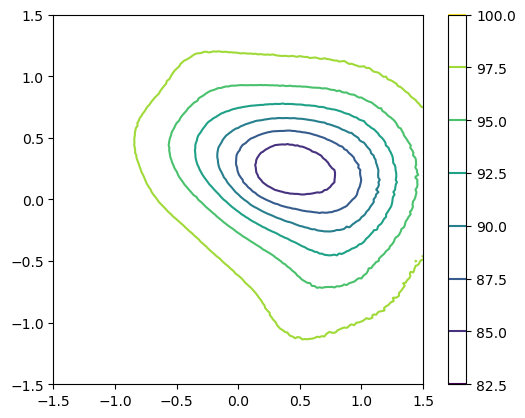

In [44]:
X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))
plt.contour(X, Y, speed_field_rec)
plt.gca().set_aspect(1)
plt.colorbar()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


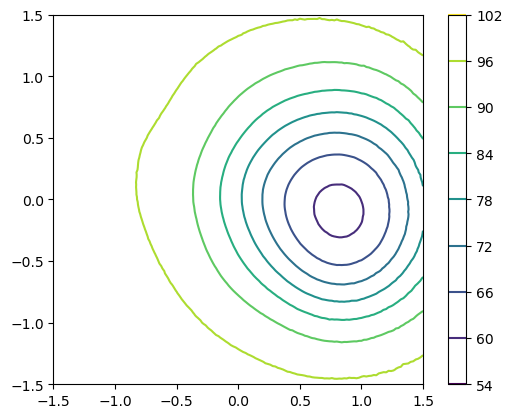

In [45]:


weights = data[idx,:]
sp_recostructed_real = decoder.predict(weights.reshape((1,ldim)))[0]*(max_sf-min_sf) + min_sf

X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))
plt.contour(X, Y, sp_recostructed_real)
plt.gca().set_aspect(1)
plt.colorbar()

In [46]:
mse(speed_field_rec.flatten(),sp_recostructed_real.flatten())

124.59536

[ 0.5   0.18 -0.42 -0.32  0.2   0.7   0.26 -0.6  -0.44  0.28  1.3   0.5
 -1.1  -0.82  0.54  1.5   0.56 -1.26 -0.96  0.62] [ 0.    0.46  0.26 -0.38 -0.46  0.    0.64  0.38 -0.54 -0.64  0.    1.2
  0.7  -1.   -1.18  0.    1.38  0.8  -1.16 -1.36] [0.02063927 0.03356832 0.03263207 0.02482971 0.0187484  0.01918144
 0.03666976 0.03560593 0.02665076 0.01889435 0.01429489 0.04489073
 0.04333836 0.03469075 0.02285996 0.01385022 0.04921651 0.0455473
 0.03809138 0.02538434]


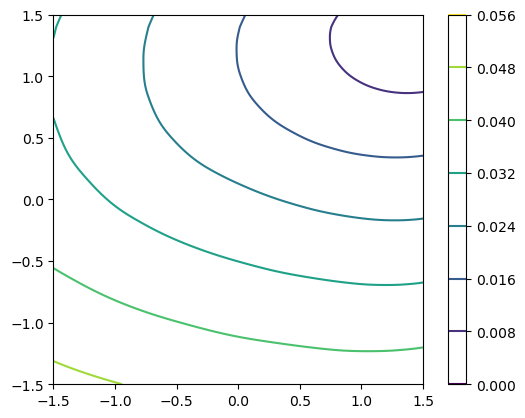

In [47]:
T = anysotropic_FMM(x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22,speed_field_rec) # downsample_sf(decoder.predict(weights.reshape((1,6)))[0]))
plt.contour(X, Y, T)
plt.gca().set_aspect(1)
plt.colorbar()
print(x_meas,y_meas,t_meas)

[ 0.5   0.18 -0.42 -0.32  0.2   0.7   0.26 -0.6  -0.44  0.28  1.3   0.5
 -1.1  -0.82  0.54  1.5   0.56 -1.26 -0.96  0.62] [ 0.    0.46  0.26 -0.38 -0.46  0.    0.64  0.38 -0.54 -0.64  0.    1.2
  0.7  -1.   -1.18  0.    1.38  0.8  -1.16 -1.36] [0.02063927 0.03356832 0.03263207 0.02482971 0.0187484  0.01918144
 0.03666976 0.03560593 0.02665076 0.01889435 0.01429489 0.04489073
 0.04333836 0.03469075 0.02285996 0.01385022 0.04921651 0.0455473
 0.03809138 0.02538434]


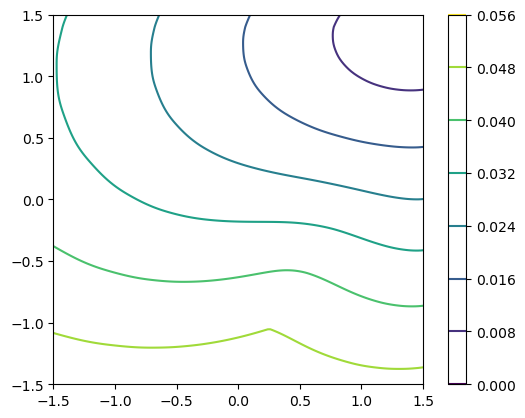

In [48]:
T_real = anysotropic_FMM(x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22,sp_recostructed_real) # downsample_sf(decoder.predict(weights.reshape((1,6)))[0]))
plt.contour(X, Y, T_real)
plt.gca().set_aspect(1)
plt.colorbar()
print(x_meas,y_meas,t_meas)

In [49]:
mse(T, T_real)

1.6365110416779717e-05